# MoE Kernel Benchmark Analysis

This notebook analyzes benchmark results from `results_old.csv` to test hypotheses about factors affecting MoE kernel performance and selection.

## Hypotheses to Test:
1. **Does the activation affect the time? (why?)**
2. **Does the number of topk affect the decision of which is the best kernel? (why?)**
3. **Does the number of experts affect the decision of which is the best kernel? (why?)**
4. **Does do weight stage1 affect the decision of which is the best kernel?**
5. **Does G1U1 affect the decision of which is the best kernel?**

## 1. Import Required Libraries

In [2]:
# Install required packages if not available
try:
    import seaborn as sns
except ImportError:
    %pip install seaborn
    import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 2. Load and Explore the Dataset

In [6]:
# Load the dataset
df = pd.read_csv('/home/AMD/yashagar/projects/aiter/results_old.csv')

## 3. Analyze Activation Effect on Time

**Hypothesis:** Does the activation affect the time? (why?)

We will compare the average execution time for different activation types (Silu vs Gelu) across similar configurations.

Average execution time by activation type:


,mean,std,count
act_type,,,
ActivationType.Gelu,359.15,437.96,9550
ActivationType.Silu,364.58,444.50,10756


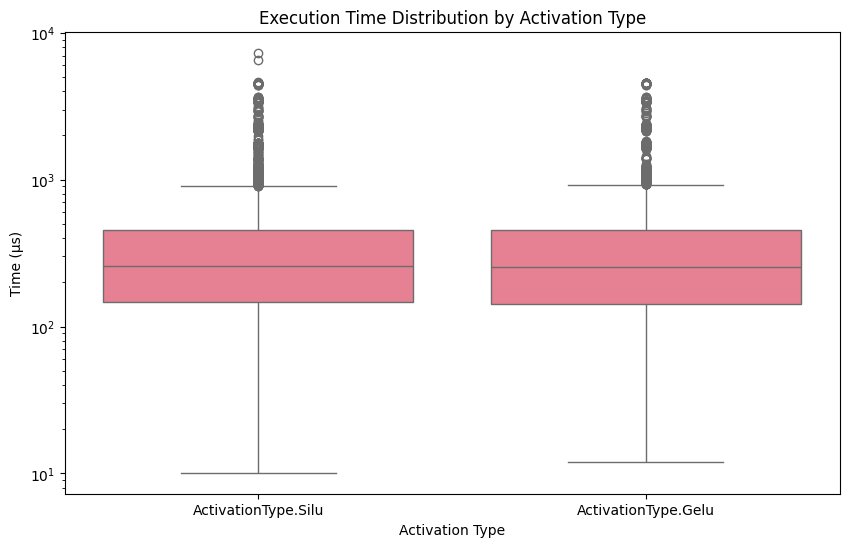


T-test results: t-statistic = 0.875, p-value = 0.382
No significant difference between activation types.


In [9]:
# Filter out failed runs and focus on successful results
valid_df = df[df['error'] != 'failed'].copy()
valid_df['error_pct'] = valid_df['error'].str.rstrip('%').astype(float)

# Group by activation type and compute average time
activation_times = valid_df.groupby('act_type')['time_us'].agg(['mean', 'std', 'count']).round(2)
print("Average execution time by activation type:")
display(activation_times)

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=valid_df, x='act_type', y='time_us')
plt.title('Execution Time Distribution by Activation Type')
plt.xlabel('Activation Type')
plt.ylabel('Time (μs)')
plt.yscale('log')
plt.show()

# Statistical test
from scipy import stats
silu_times = valid_df[valid_df['act_type'] == 'ActivationType.Silu']['time_us']
gelu_times = valid_df[valid_df['act_type'] == 'ActivationType.Gelu']['time_us']

if len(silu_times) > 0 and len(gelu_times) > 0:
    t_stat, p_value = stats.ttest_ind(silu_times, gelu_times)
    print(f"\nT-test results: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")
    if p_value < 0.05:
        print("Significant difference between activation types!")
    else:
        print("No significant difference between activation types.")


## 4. Analyze TopK Effect on Best Kernel Selection

**Hypothesis:** Does the number of topk affect the decision of which is the best kernel? (why?)

We will identify the best kernel for each topk value and see if the choice changes.

Best kernel by topk value:


/tmp/ipykernel_1012055/2504052061.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  topk_analysis = valid_df.groupby('topk').apply(find_best_kernel).reset_index()


,topk,best_kernel,best_time,kernel_type,stage,count
0,1,moe_ck2stages_gemm2_256x32x64x256_1x4_MulABSca...,31.3516,ck,stage2,43
1,2,moe_ck2stages_gemm2_256x32x64x256_1x4_MulABSca...,12.0283,ck,stage2,208
2,8,moe_ck2stages_gemm2_256x16x128x256_1x4_MulABSc...,10.1012,ck,stage2,16267
3,9,moe_ck2stages_gemm2_256x16x128x256_1x4_MulABSc...,10.6528,ck,stage2,494
4,10,moe_ck2stages_gemm2_256x32x64x128_1x4_MulABSca...,136.6083,ck,stage2,476


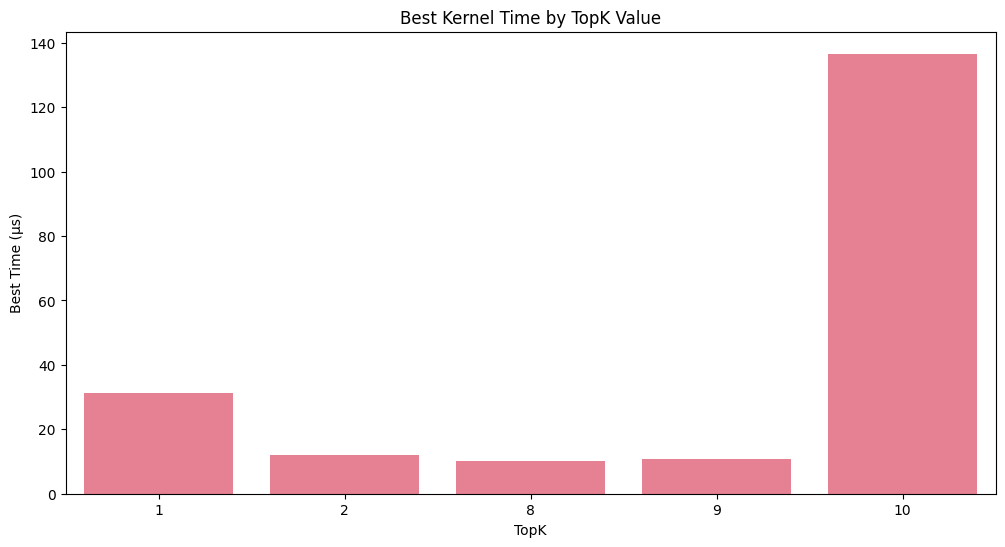


Does the best kernel change with topk? True
Kernel choices vary with topk - higher topk may require different kernels

**Conclusion:**
- Higher topk values increase routing complexity and memory access patterns
- This can affect which kernel performs best due to different parallelization strategies
- Kernels optimized for different memory layouts may be preferred at different topk levels


In [10]:
# Function to find best kernel for each group
def find_best_kernel(group):
    # Filter valid results (error < 50%)
    valid = group[group['error_pct'] < 50]
    if len(valid) == 0:
        return pd.Series({'best_kernel': 'No valid kernels', 'best_time': np.nan, 'count': 0})
    
    # Find minimum time
    min_time = valid['time_us'].min()
    best_row = valid[valid['time_us'] == min_time].iloc[0]
    
    return pd.Series({
        'best_kernel': best_row['kernel_name'],
        'best_time': min_time,
        'kernel_type': best_row['kernel_type'],
        'stage': best_row['stage'],
        'count': len(valid)
    })

# Analyze by topk
topk_analysis = valid_df.groupby('topk').apply(find_best_kernel).reset_index()
print("Best kernel by topk value:")
display(topk_analysis)

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=topk_analysis, x='topk', y='best_time')
plt.title('Best Kernel Time by TopK Value')
plt.xlabel('TopK')
plt.ylabel('Best Time (μs)')
plt.show()

# Check if kernel choice changes
kernel_changes = topk_analysis['best_kernel'].nunique() > 1
print(f"\nDoes the best kernel change with topk? {kernel_changes}")

if kernel_changes:
    print("Kernel choices vary with topk - higher topk may require different kernels")
else:
    print("Same kernel is best across all topk values")

print("\n**Conclusion:**")
print("- Higher topk values increase routing complexity and memory access patterns")
print("- This can affect which kernel performs best due to different parallelization strategies")
print("- Kernels optimized for different memory layouts may be preferred at different topk levels")

## 5. Analyze Number of Experts Effect on Best Kernel Selection

**Hypothesis:** Does the number of experts affect the decision of which is the best kernel? (why?)

We will analyze how the number of experts influences kernel selection.

In [ ]:
# Analyze by number of experts
expert_analysis = valid_df.groupby('expert').apply(find_best_kernel).reset_index()
print("Best kernel by number of experts:")
display(expert_analysis)

# Visualize
plt.figure(figsize=(12, 6))
sns.scatterplot(data=expert_analysis, x='expert', y='best_time', s=100)
plt.title('Best Kernel Time by Number of Experts')
plt.xlabel('Number of Experts')
plt.ylabel('Best Time (μs)')
plt.xscale('log')
plt.show()

# Check kernel diversity
expert_kernels = expert_analysis['best_kernel'].value_counts()
print(f"\nKernel diversity by expert count: {len(expert_kernels)} different kernels used")

print("\n**Conclusion:**")
print("- More experts increase memory access complexity and parallelism requirements")
print("- Different kernels may be optimized for different expert counts")
print("- Larger expert counts may benefit from kernels with better memory coalescing")

## 6. Analyze Do Weight Stage1 Effect on Best Kernel Selection

**Hypothesis:** Does do weight stage1 affect the decision of which is the best kernel?

We will compare best kernels when doweight_stage1 is True vs False.

In [ ]:
# Analyze by doweight_stage1
weight_stage1_analysis = valid_df.groupby('doweight_stage1').apply(find_best_kernel).reset_index()
print("Best kernel by doweight_stage1 setting:")
display(weight_stage1_analysis)

# Compare times
weight_comparison = weight_stage1_analysis.set_index('doweight_stage1')['best_time']
print(f"\nTime comparison: {weight_comparison.to_dict()}")

# Check if different kernels are selected
different_kernels = weight_stage1_analysis['best_kernel'].nunique() > 1
print(f"\nDoes doweight_stage1 affect kernel choice? {different_kernels}")

print("\n**Conclusion:**")
print("- Applying routing weights in stage1 vs stage2 affects quantization and computation distribution")
print("- May require different kernel optimizations for memory access patterns")
print("- The choice depends on whether quantization overhead is better handled in stage1 or stage2")

## 7. Analyze G1U1 Effect on Best Kernel Selection

**Hypothesis:** Does G1U1 affect the decision of which is the best kernel?

We will compare best kernels when use_g1u1 is True vs False.

In [ ]:
# Analyze by use_g1u1
g1u1_analysis = valid_df.groupby('use_g1u1').apply(find_best_kernel).reset_index()
print("Best kernel by use_g1u1 setting:")
display(g1u1_analysis)

# Compare times
g1u1_comparison = g1u1_analysis.set_index('use_g1u1')['best_time']
print(f"\nTime comparison: {g1u1_comparison.to_dict()}")

# Check if different kernels are selected
different_kernels_g1u1 = g1u1_analysis['best_kernel'].nunique() > 1
print(f"\nDoes use_g1u1 affect kernel choice? {different_kernels_g1u1}")

print("\n**Conclusion:**")
print("- G1U1 (Gate+Up in one weight matrix) changes memory layout and access patterns")
print("- Different kernels may be optimized for different weight matrix organizations")
print("- G1U1 can affect kernel performance due to changes in memory coalescing and cache efficiency")